In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
!pip install transformer_lens
!pip uninstall jax jaxlib -y
!pip install jax jaxlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.9/109.9 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 64.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 74.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 40.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.12.0
    Uninstalling huggingface-hub-0.12.0:
      Successfully uninstalled huggingface-h

In [14]:
from transformer_lens import HookedTransformer
from transformer_lens import utils as tl_utils
import torch
import numpy as np

import json
import time

from src.neuron_heads import head_attribution_over_all_data
from src.datahandlers import ActivatingDataset
from src.utils import tuple_str_to_tuple

In [86]:
# Load jsons from ../experiment_data/1_next_token_neurons
# filename = "2023-10-12_10-51-10_gpt2-large"
# filename = "2023-10-13_07-03-35_gpt2-small_test"
# filename = "2023-10-13_07-54-07_gpt2-medium_test"
# filename = "2023-10-13_12-36-52_gpt2-large_test"
# filename = "2023-10-14_08-18-02_gpt2-large_mid"
# filename = "2023-10-14_18-20-09_gpt2-large_mid_test"

# nh_filename = "2023-10-14_16-16-07_gpt2-small_prompts"
# nh_filename = "2023-10-14_16-15-00_gpt2-medium_prompts"
nh_filename = "2023-10-14_16-13-57_gpt2-large_prompts"

# ha_filename = "2023-10-13_13-51-37_gpt2-small_test"
# ha_filename = "2023-10-13_14-02-06_gpt2-medium_test"
ha_filename = "2023-10-13_14-17-42_gpt2-large_test"

with open(f"../experiment_data/4_head_attributions/{nh_filename}.json") as f:
    nh_data = json.load(f)

with open(f'../experiment_data/4_head_attributions/{ha_filename}.json') as f:
    head_attributions = json.load(f)


trimmed_texts_filename = head_attributions['prior_filename']
with open(f'../experiment_data/3_trimmed_texts/{trimmed_texts_filename}.json') as f:
    trimmed_texts = json.load(f)

max_activating_filename = trimmed_texts['prior_filename']
with open(f'../experiment_data/2_max_activating_texts/{max_activating_filename}.json') as f:
    max_activating = json.load(f)

neuron_filename = max_activating['prior_filename']
with open(f'../experiment_data/1_next_token_neurons/{neuron_filename}.json') as f:
    neurons_data = json.load(f)

neurons = [tuple_str_to_tuple(x) for x in trimmed_texts['neuron_to_trunc_data'].keys()]

nh_list = [tuple_str_to_tuple(x) for x in nh_data['nh_to_pos_neg_prompts'].keys()]

neuron_to_token = {tuple_str_to_tuple(neuron_str): token_data['token'] for neuron_str, token_data in neurons_data['neurons'].items()}

In [4]:
!ls experiment_data/3_trimmed_texts

2023-10-12_06-52-17_gpt2-small.json
2023-10-12_07-15-42_gpt2-medium.json
2023-10-12_10-51-10_gpt2-large.json
2023-10-12_10-51-25_gpt2-large.json
2023-10-13_07-03-35_gpt2-small_test.json
2023-10-13_07-54-07_gpt2-medium_test.json
2023-10-13_12-36-52_gpt2-large_test.json
2023-10-14_08-18-02_gpt2-large_mid.json
2023-10-14_18-20-09_gpt2-large_mid_test.json


In [87]:
# from datasets import load_dataset
# dataset = load_dataset("NeelNanda/pile-10k", split="train")
# dataset_text_list = [x['text'] for x in dataset]


import pickle

with open('../experiment_data//text_list_dict_test.pkl', 'rb') as f:
    dataset_text_dict = pickle.load(f)

dataset_text_list = [x['text'] for x in dataset_text_dict]
dataset = dataset_text_dict

data = ActivatingDataset(trimmed_texts['neuron_to_trunc_data'], dataset)
data.remove_prompts_longer_than(100)

In [88]:
# Parameters
parameters = trimmed_texts['parameters']
model_name = parameters['model_name']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [89]:
model = HookedTransformer.from_pretrained(
    model_name,
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
    device=device,
)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-large into HookedTransformer


In [90]:
nh_to_relevant_mask = {}
head_attribution_dict = head_attributions['head_attributions']


for nh in tqdm(nh_list):
    nh_mask = []
    neuron, head = (nh[0], nh[1]), nh[2]
    prompts, prompts_metadata = data.load_truncated_prompts(model, neuron)

    for prompt in prompts:
        if head in head_attribution_dict[str(neuron)][prompt]:
            nh_mask.append(1)
        else:
            nh_mask.append(0)

    nh_to_relevant_mask[nh] = nh_mask

100%|██████████| 612/612 [01:29<00:00,  6.86it/s]


In [91]:
nh_token_prob_attn_ablated_vs_normal = {}
with torch.no_grad():
    for nh in tqdm(nh_list):
        model.reset_hooks()
        neuron, head = (nh[0], nh[1]), nh[2]
        token = neuron_to_token[neuron]

        prompts, prompts_metadata = data.load_truncated_prompts(model, neuron)

        # def return_ablation_hook(layer, head):
        #     def hook(module, input, output):
        #         output[:, :, head, :] = 0
        #         return output
        #     return hook
        NUM_HEADS = model.cfg.n_heads
        head_index_to_ablate = head%NUM_HEADS
        layer_to_ablate = head//NUM_HEADS

        def ablation_hook(value, hook):
            value[:, :, head_index_to_ablate, :] = 0


        x = model.run_with_hooks(
            model.to_tokens(prompts).to(device),
            # fwd_hooks=hooks,
            fwd_hooks = [(tl_utils.get_act_name("v", layer_to_ablate), ablation_hook)]
        )
        # Softmax x, according to the token index
        x = torch.softmax(x, dim=-1)
        token_index = model.tokenizer.encode(token)[0]
        # print(token_index)
        x = x[:, :, token_index]

        # Get the activation of the neuron
        tokens = model.to_tokens(prompts)

        pad_token = bos_token = 50256 # This is true for GPT-2
        prompt_lengths = (torch.logical_and(tokens != pad_token, tokens != bos_token)).sum(dim=-1)

        # neuron_acts = tokens
        # print(neuron_acts.shape)
        # x = tokens

        # Create indices to gather the last elements
        batch_size = x.size(0)
        max_length = x.size(1)
        last_indices = prompt_lengths  # Subtract 1 to get the last element index

        # Create indices tensor to gather from neuron_acts
        indices = torch.arange(0, batch_size) * max_length + last_indices.unsqueeze(1)


        # Gather the last elements from neuron_acts
        head_output_last_seq = torch.gather(x.view(-1), 0, indices.view(-1))
        head_output_last_seq = head_output_last_seq.view(batch_size, -1)
        head_output_last_seq = torch.diag(head_output_last_seq)

        ablated_probs = head_output_last_seq# .tolist()

        model.reset_hooks()

        x = model(model.to_tokens(prompts).to(device))
        # Softmax x, according to the token index
        x = torch.softmax(x, dim=-1)
        token_index = model.tokenizer.encode(token)[0]
        # print(token_index)
        x = x[:, :, token_index]

        # Get the activation of the neuron
        tokens = model.to_tokens(prompts)

        pad_token = bos_token = 50256 # This is true for GPT-2
        prompt_lengths = (torch.logical_and(tokens != pad_token, tokens != bos_token)).sum(dim=-1)

        # neuron_acts = tokens
        # print(neuron_acts.shape)
        # x = tokens

        # Create indices to gather the last elements
        batch_size = x.size(0)
        max_length = x.size(1)
        last_indices = prompt_lengths  # Subtract 1 to get the last element index

        # Create indices tensor to gather from neuron_acts
        indices = torch.arange(0, batch_size) * max_length + last_indices.unsqueeze(1)


        # Gather the last elements from neuron_acts
        head_output_last_seq = torch.gather(x.view(-1), 0, indices.view(-1))
        head_output_last_seq = head_output_last_seq.view(batch_size, -1)
        head_output_last_seq = torch.diag(head_output_last_seq)

        normal_probs = head_output_last_seq# .tolist()

        prob_normal_relevant = [normal_probs[i] for i in range(len(normal_probs)) if nh_to_relevant_mask[nh][i] == 1]
        prob_normal_irrelevant = [normal_probs[i] for i in range(len(normal_probs)) if nh_to_relevant_mask[nh][i] == 0]

        prob_ablate_relevant = [ablated_probs[i] for i in range(len(ablated_probs)) if nh_to_relevant_mask[nh][i] == 1]
        prob_ablate_irrelevant = [ablated_probs[i] for i in range(len(ablated_probs)) if nh_to_relevant_mask[nh][i] == 0]


        # prob_diff_relevant = np.mean(np.abs(np.array(prob_normal_relevant) - np.array(prob_ablate_relevant)))
        # prob_diff_irrelevant = np.mean(np.abs(np.array(prob_normal_irrelevant) - np.array(prob_ablate_irrelevant)))
        prob_diff_relevant = np.mean(np.array(prob_normal_relevant) - np.array(prob_ablate_relevant))
        prob_diff_irrelevant = np.mean(np.array(prob_normal_irrelevant) - np.array(prob_ablate_irrelevant))


        nh_token_prob_attn_ablated_vs_normal[nh] = {"ablated": ablated_probs, "normal": normal_probs, 'act_diff_relevant': prob_diff_relevant, 'act_diff_irrelevant': prob_diff_irrelevant}

 10%|▉         | 60/612 [06:34<56:08,  6.10s/it]  /Users/clementneo/projects/Neuron_groups/neuron_groups/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/clementneo/projects/Neuron_groups/neuron_groups/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 612/612 [1:13:30<00:00,  7.21s/it]


In [101]:
# pickle nh_token_prob_attn_ablated_vs_normal

# with open('../experiment_data/7_head_ablation/nh_token_prob_attn_ablated_vs_normal_noabs_large.pkl', 'wb') as f:
    # pickle.dump(nh_token_prob_attn_ablated_vs_normal, f)

# Load all of them

with open('../experiment_data/7_head_ablation/nh_token_prob_attn_ablated_vs_normal_noabs_small.pkl', 'rb') as f:
    nh_token_prob_attn_ablated_vs_normal_small = pickle.load(f)

with open('../experiment_data/7_head_ablation/nh_token_prob_attn_ablated_vs_normal_noabs_medium.pkl', 'rb') as f:
    nh_token_prob_attn_ablated_vs_normal_medium = pickle.load(f)

with open('../experiment_data/7_head_ablation/nh_token_prob_attn_ablated_vs_normal_noabs_large.pkl', 'rb') as f:
    nh_token_prob_attn_ablated_vs_normal_large = pickle.load(f)

# Load NH list for each model
nh_filename_small = "2023-10-14_16-16-07_gpt2-small_prompts"
nh_filename_medium = "2023-10-14_16-15-00_gpt2-medium_prompts"
nh_filename_large = "2023-10-14_16-13-57_gpt2-large_prompts"

with open(f"../experiment_data/4_head_attributions/{nh_filename_small}.json") as f:
    nh_data = json.load(f)
nh_list_small = [tuple_str_to_tuple(x) for x in nh_data['nh_to_pos_neg_prompts'].keys()]

with open(f"../experiment_data/4_head_attributions/{nh_filename_medium}.json") as f:
    nh_data = json.load(f)
nh_list_medium = [tuple_str_to_tuple(x) for x in nh_data['nh_to_pos_neg_prompts'].keys()]

with open(f"../experiment_data/4_head_attributions/{nh_filename_large}.json") as f:
    nh_data = json.load(f)
nh_list_large = [tuple_str_to_tuple(x) for x in nh_data['nh_to_pos_neg_prompts'].keys()]

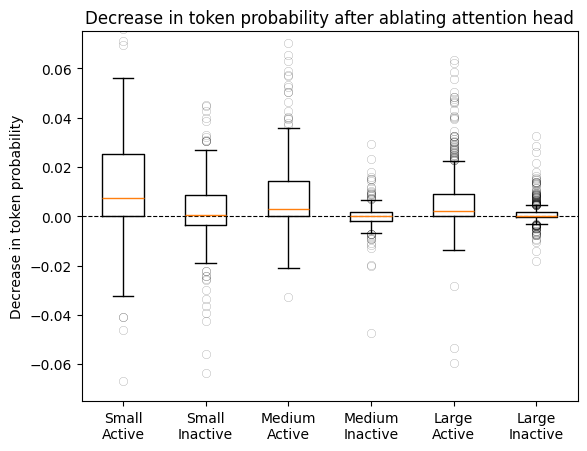

In [123]:
import matplotlib.pyplot as plt

# Calculate the difference 
nh_token_prob_attn_ablated_vs_normal_diff = {}

relevant_list_small, irrelevant_list_small = [], []
relevant_list_medium, irrelevant_list_medium = [], []
relevant_list_large, irrelevant_list_large = [], []
for nh in nh_list_small:
    prob_diff_relevant = nh_token_prob_attn_ablated_vs_normal_small[nh]["act_diff_relevant"]
    prob_diff_irrelevant = nh_token_prob_attn_ablated_vs_normal_small[nh]["act_diff_irrelevant"]
    if not np.isnan(prob_diff_relevant):
        relevant_list_small.append(prob_diff_relevant)
    if not np.isnan(prob_diff_irrelevant):
        irrelevant_list_small.append(prob_diff_irrelevant)

for nh in nh_list_medium:
    prob_diff_relevant = nh_token_prob_attn_ablated_vs_normal_medium[nh]["act_diff_relevant"]
    prob_diff_irrelevant = nh_token_prob_attn_ablated_vs_normal_medium[nh]["act_diff_irrelevant"]

    if not np.isnan(prob_diff_relevant):
        relevant_list_medium.append(prob_diff_relevant)
    if not np.isnan(prob_diff_irrelevant):
        irrelevant_list_medium.append(prob_diff_irrelevant)

for nh in nh_list_large:
    prob_diff_relevant = nh_token_prob_attn_ablated_vs_normal_large[nh]["act_diff_relevant"]
    prob_diff_irrelevant = nh_token_prob_attn_ablated_vs_normal_large[nh]["act_diff_irrelevant"]

    if not np.isnan(prob_diff_relevant):
        relevant_list_large.append(prob_diff_relevant)
    if not np.isnan(prob_diff_irrelevant):
        irrelevant_list_large.append(prob_diff_irrelevant)
        

# print(len(diff_list))
# print(np.mean(diff_list), np.std(diff_list))
# print(np.mean(relevant_list), np.std(relevant_list))
# print(np.mean(irrelevant_list), np.std(irrelevant_list))

# scatter(np.arange(len(diff_list)), diff_list)
plt.plot([0.5, 6.5], [0, 0], linestyle='--', color='k', linewidth=0.8)
flier_props = dict(marker='o', markersize=6, markerfacecolor='none', alpha=1, markeredgecolor='k', markeredgewidth=0.1)
plt.boxplot((relevant_list_small, irrelevant_list_small, relevant_list_medium, irrelevant_list_medium, relevant_list_large, irrelevant_list_large),
            labels=['Small\nActive', 'Small\nInactive', 'Medium\nActive', 'Medium\nInactive', 'Large\nActive', 'Large\nInactive'],
            flierprops=flier_props)
plt.ylim(-0.075, 0.075)
plt.ylabel("Decrease in token probability")
plt.title("Decrease in token probability after ablating attention head")
# draw a dotted line at y=0
plt.savefig("../figures/v2_ablation_token_prob_noabs_scales.pdf")

In [124]:
# perform the two-sample Kolmogorov-Smirnov test
from scipy.stats import ks_2samp
print("Small")
print(ks_2samp(relevant_list_small, irrelevant_list_small))
print("Medium")
print(ks_2samp(relevant_list_medium, irrelevant_list_medium))
print("Large")
print(ks_2samp(relevant_list_large, irrelevant_list_large))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Small
KstestResult(statistic=0.2418614813196417, pvalue=1.0247127961926815e-05, statistic_location=0.0029031031, statistic_sign=-1)
Medium
KstestResult(statistic=0.3311387610776583, pvalue=3.6874698042384336e-13, statistic_location=0.003135332, statistic_sign=-1)
Large
KstestResult(statistic=0.29317396787104555, pvalue=2.0894921062683864e-23, statistic_location=0.0047357297, statistic_sign=-1)
